In [1]:
import sklearn
from sklearn.datasets import make_moons,make_circles
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import keras
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


### Data Generation
We generate a simple one dimensional manifold in two dimensions to illustrate how AC can capture local manifold information
DAC in comparison to Vanilla AC

(1000, 7)


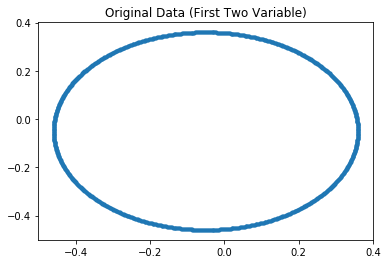

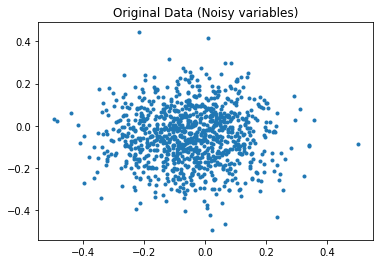

In [2]:
theta = np.arange(2*np.pi, 6*np.pi, 0.001)
a = 1
b = .2
dt=.1
x = a*np.cos(theta + dt)*np.exp(b*theta)
y = a*np.sin(theta + dt)*np.exp(b*theta)
x=x-min(x)
x=x/max(x)
y=y-min(y)
y=y/max(y)
X=np.concatenate([np.expand_dims(x,0),np.expand_dims(y,0)],axis=0).T
X=X-.5

from sklearn.datasets import make_blobs

# generate ring with inner box
n_samples = 2000
X, y = make_circles(n_samples=n_samples, factor=.5, noise=0, shuffle=False)
X=X[y==0,:]
varnoise=5
X=np.concatenate([X,np.random.randn(X.shape[0],varnoise)/3],axis=1)
X=X-np.min(X)
X=X/np.max(X)
X=X-.5
print(X.shape)

plt.plot(X[:,0],X[:,1],'.')
plt.title('Original Data (First Two Variable)')
plt.show()

plt.plot(X[:,2],X[:,3],'.')
plt.title('Original Data (Noisy variables)')
plt.show()

In [3]:
np.random.randn(X.shape[0],3).shape

(1000, 3)

In [4]:
from keras.models import Model 
from keras.layers import Input, Dense
from keras.layers import GaussianNoise
from keras.callbacks import EarlyStopping
#Example of Standard Autoencoder
dim_input=X.shape[1]
dim_latent_space=2

### Autoencoder

In [5]:
input_img = Input(shape=(dim_input,))

#Traditional AC
#x = Dense(10,name='encoded1')(input_img)

#Denoising AC
x = GaussianNoise(.01)(input_img)
x = Dense(10,activation='relu',name='encoded1')(x)

x = Dense(5,activation='relu')(x)
encoded1 = Dense(5,name='encoded2',activation='relu')(x)
z = Dense(dim_latent_space,name='latent')(encoded1)
w = Dense(5,activation='relu')(z)
w = Dense(5,activation='relu')(w)
decoder1 = Dense(5,activation='relu')(w)
y = Dense(dim_input,name='y')(decoder1)
autoencoder = Model(input_img, y)
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7)                 0         
_________________________________________________________________
encoded1 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
encoded2 (Dense)             (None, 5)                 30        
_________________________________________________________________
latent (Dense)               (None, 2)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 15        
__________

### Encoder

In [6]:
#Encoder is easy to extract because 
encoder = Model(input_img, z)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7)                 0         
_________________________________________________________________
encoded1 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
encoded2 (Dense)             (None, 5)                 30        
_________________________________________________________________
latent (Dense)               (None, 2)                 12        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


### Decoder

In [7]:
# # create a placeholder for an encoded input with the same dimension that in the latent space
# encoded_input = Input(shape=(dim_latent_space,))
# # retrieve the last layer of the autoencoder model
# decoder1 = autoencoder.layers[-2]
# decoder2 = autoencoder.layers[-1]
# # create the decoder model
# decoder = Model(encoded_input, decoder2(decoder1(encoded_input)))
# decoder.summary()

In [8]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

print('Fitting Autoencoder')

ES=EarlyStopping(monitor='loss', patience=3)
history =autoencoder.fit(X, X,epochs=100,batch_size=64,shuffle=True,callbacks=[ES])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7)                 0         
_________________________________________________________________
encoded1 (Dense)             (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
encoded2 (Dense)             (None, 5)                 30        
_________________________________________________________________
latent (Dense)               (None, 2)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 15        
__________

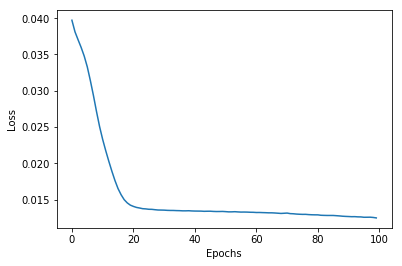

In [9]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

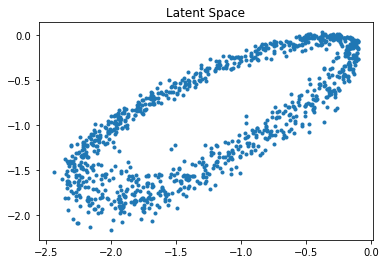

In [10]:
pred=encoder.predict(X)
plt.plot(pred[:,0],pred[:,1],'.')
plt.title('Latent Space')
plt.show()

###  We would like to visualize the derivative of the encoder to see their relationship with the original manifold

In [11]:
import keras.backend as K
def get_gradients_function(model):
    weights = model.trainable_weights # weight tensors
    gradients = model.optimizer.get_gradients(model.total_loss, weights)
    input_tensors = model.inputs + model.sample_weights + model.targets + [K.learning_phase()]
    get_gradients = K.function(inputs=input_tensors, outputs=gradients)
    return get_gradients

def get_gradient_data(get_gradients,x,y,nsamples=0):
    if nsamples==0:
        inputs = [x, np.ones(x.shape[0]), y, 0]
    else:
        inputs = [x, np.ones(nsamples), y, 0]
    output=get_gradients(inputs)
    output=[(np.clip(grad,-.01,.01)) for grad in output]
    return output

In [12]:
from keras.objectives import mse
loss = K.mean(mse(autoencoder.input, autoencoder.output))
label=autoencoder.input
get_grads = K.function([autoencoder.input, label], K.gradients(loss, autoencoder.input))
#grads = get_grads([X[0:1,:]])

### Sink effect
A good autoencoder should have a sink in the manifold

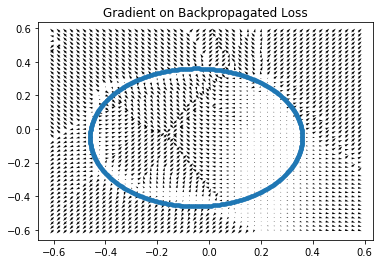

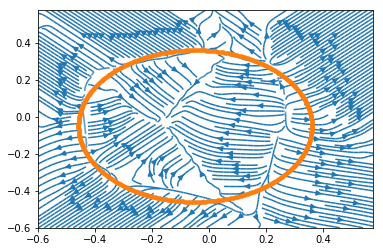

In [13]:
Xi, Yi = np.meshgrid(np.arange(-.6, .6, .025), np.arange(-.6, .6, .025))
U = np.zeros(Xi.shape)
V = np.zeros(Yi.shape)
for i in range(len(U)):
    for j in range(len(U)):
        test=np.zeros(X.shape[1])
        test[0]=Xi[i,j]
        test[1]=Yi[i,j]
        test=np.expand_dims(test,0)
        #G=get_gradient_data(get_grad_auto,test,test)
        #G=G[0]
        #G=sum(G[0])
        G = get_grads([test])[0][0]
        G=np.clip(G,-.01,.01)
        U[i,j]=G[0]
        V[i,j]=G[1]
plt.figure()
plt.title('Gradient on Backpropagated Loss')
plt.plot(X[:, 0], X[:, 1],'.')
plt.quiver(Xi, Yi, U, V, units='width')
plt.show()

plt.streamplot(Xi, Yi, U, V,density=2)
plt.plot(X[:, 0], X[:, 1],'.')
plt.show()